# Bayesian Online Changepoint Detection
* It is a probabilistic model to identify the level shifts(mean-shifts) or variational shifts in incoming dataset
* It predicts posterior probability of run length(interval between to changepoints in dataset) so for a dataset of n-samples, there are n-possible run lengths.
* The model calculates probability that all those possible run lengths for each datapoint to be changepoints so it creates $NxN$ matrix where $N$ is length of the dataset
* So we set default threshold probability for it be a changepoint is $0.5$.

## Required Arguments to run the program:

* All of the algorithm related parameters are optional which has a default value given in the program itself.
* Description for each argument is given below :

* algo_kwargs={
            'is_train':Takes Boolean argument true or false, true for model which requires training,
            'data_col_index':1  -> column index from which metrics to be considered for anomaly detection ,
            'pthres':thres_prob -> probability after which a point is considered as changepoint,
            'Nw':samples_to_wait -> samples to wait before detecting changepoints,
            'mean_runlen':expected_run_length -> average run length between two change points in dataset
        }
        
* So the default value given are as follows:
     * algo_kwargs={
            'is_train':False,
            'data_col_index':1,
            'pthres':0.5,
            'Nw':10,
            'mean_runlen':100
        }

## Dependencies :
* Download https://github.com/hildensia/bayesian_changepoint_detection this and run **python setup.py install** to install the bayesian changepoint detection module.
* Install **psycopg2** module using pip to connect to postgresql db
* Install **writefile_run** using pip , which is used to save the cell in a python file automatically

In [1]:
import writefile_run as writefile_run

In [2]:
%%writefile_run bayeschangept_sprint1.py

'''
importing all the required header files
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import datetime as dt
import time
import os

# Importing reader and checker python files as modules
import db_properties as db_props
import writer_configs as write_args
import psycopg2

from preprocessors import *
from data_handler import *
from bayesian_changept_detector import *

import error_codes as error_codes
import type_checker as type_checker
import json
import traceback
import warnings
warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = 12, 9
rcParams[ 'axes.grid']=True

/home/rohithram/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Use scipy logsumexp().


In [3]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
%%writefile_run bayeschangept_sprint1.py -a

'''
ideal argument types for algorithm
'''
algo_params_type ={
            'is_train':bool,
            'data_col_index':int,
            'pthres':float or int,
            'Nw':int,
            'mean_runlen':int
        }

In [5]:
%%writefile_run bayeschangept_sprint1.py -a


def call(assetno,from_timestamp,to_timestamp,con,para_list,source_type='opentsdb',table_name='',
        qry_str='',impute_fill_method='forward',down_sampling_method=None,down_sampling_window=None,freq=None,
        resample_fill_method=None,to_resample=None,to_impute=None,thres_prob=0.5,samples_to_wait=10,expected_run_length=100):

        '''
        Wrapper function which should be called inorder to run the anomaly detection, it has four parts :
        *reader           - Class Data_reader defined in data_handler.py which takes in reader args and parses json 
                            and gives dataframes
        *preprocessor     - preprocessors are defined in preprocessors.py, which takes in data and gives out processed 
                            data
        *anomaly detector - Class Bayesian_Changept_Detector defined in bayesian_changept_detector.py, which takes in
                            data and algorithm parameters as argument and returns anomaly indexes and data.        
        *writer           - Class Postgres_Writer defined in data_handler.py which takes in anomaly detector object and
                            and sql_queries , db_properties and table name as args and gives out response code.
        
        Arguments :
        It takes reader args as of now to get the dataset and algo related arguments
        Note:
        To run this, import this python file as module and call this function with required args and it will detect
        anomalies and writes to the local database.
        This algorithm is univariate, so each metric per asset is processed individually
        '''
        
        #reader arguments
        reader_kwargs={
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':para_list,
            'source_type':source_type,
            'table_name':table_name,
            'qry_str':qry_str,
            'impute_fill_method':impute_fill_method,
            'down_sampling_method':down_sampling_method,
            'down_sampling_window':down_sampling_window,
            'freq':freq,
            'resample_fill_method':resample_fill_method,
            'to_resample':to_resample,
            'to_impute':to_impute
        }

        #algorithm arguments
        algo_kwargs={
            'is_train':False,
            'data_col_index':1,
            'pthres':thres_prob,
            'Nw':samples_to_wait,
            'mean_runlen':expected_run_length
        }
                    
        try: 
            '''
            #reseting the error_codes to avoid overwritting
            #error_codes is a python file imported as error_codes which has error_codes dictionary mapping 
            #for different kinds errors and reset function to reset them.
            '''
            
            error_codes.reset()
            # type_checker is python file which has Type_checker class which checks given parameter types
            checker = type_checker.Type_checker(kwargs=algo_kwargs,ideal_args_type=algo_params_type)
            # res is None when no error raised, otherwise it stores the appropriate error message
            res = checker.params_checker()
            if(res!=None):
                return res
            
            # instanstiating the reader class with reader arguments
            data_reader = Data_reader(reader_kwargs=reader_kwargs)
            #getting list of dataframes per asset if not empty
            #otherwise gives string 'Empty Dataframe'
            entire_data = data_reader.read()
            
            writer_data = []
            anomaly_detectors = []
            if((len(entire_data)!=0 and entire_data!=None and type(entire_data)!=dict)):

                '''
                looping over the data per assets and inside that looping over metrics per asset
                * Instantiates anomaly detector class with algo args and metric index to detect on
                * Stores the anomaly indexes and anomaly detector object to bulk write to db at once
                '''

                for i,data_per_asset in enumerate(entire_data):
                    assetno = reader_kwargs['assetno'][i]
                    data_per_asset[data_per_asset.columns[1:]] = normalise_standardise(data_per_asset[data_per_asset.columns[1:]])

                    for data_col in range(1,len(data_per_asset.columns[1:])+1):
                        algo_kwargs['data_col_index'] = data_col
                        print("\nAnomaly detection for AssetNo : {} , Metric : {}\n ".format(assetno,data_per_asset.columns[data_col]))
                        anomaly_detector = Bayesian_Changept_Detector(data_per_asset,assetno=assetno,**algo_kwargs)
                        data,anom_indexes = anomaly_detector.detect_anomalies()

                        sql_query_args = write_args.writer_kwargs
                        table_name = write_args.table_name
                        window_size = 10

                        anomaly_detectors.append(anomaly_detector)

                '''
                Instantiates writer class to write into local database with arguments given below
                Used for Bulk writing
                '''
                writer = Postgres_Writer(anomaly_detectors,db_credentials=db_props.db_connection,sql_query_args=sql_query_args,
                                        table_name=table_name,window_size=window_size)

                #called for mapping args before writing into db
                res = writer.map_outputs_and_write()
                return res
            else:
                '''
                Data empty error
                '''
                return error_codes.error_codes['data_missing']
        except Exception as e:
            '''
            unknown exceptions are caught here and traceback used to know the source of the error
            '''
            traceback.print_exc()
            error_codes.error_codes['unknown']['message']=e
            return error_codes.error_codes['unknown']

In [6]:
# %%writefile_run bayeschangept_sprint1.py -a

'''
Arguments for reader module to get data from opentsdb
This is included for now just for testing, later the main function will take json as direct input
'''

assetno = ['1']
con = '52.173.76.89:4242'
src_type =  'opentsdb'
param = ['FE-001.DRIVEENERGY']
from_timestamp = 1520402214
to_timestamp = 1520407294

In [7]:
# %%writefile_run bayeschangept_sprint1.py -a

'''
Dictionary of arguments given to wrapper function which executes this whole program for detecting changepoints and writing
to database
'''
kwargs = {
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100
        }

   
res = call(**kwargs)
print(res)

Data reader initialised 

{'code': '404', 'status': 'Not Found', 'message': "(<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7f01fde09b08>)"}


## Testing the algo on sample csv datasets

In [8]:
kwargs = lambda :{
            'assetno':assetno,
            'from_timestamp':from_timestamp,
            'to_timestamp':to_timestamp,
            'con':con,
            'para_list':param,
            'source_type':src_type,
            'table_name':'',
            'qry_str':'',
            'impute_fill_method':'forward',
            'down_sampling_method':None,
            'down_sampling_window':None,
            'freq':None,
            'resample_fill_method':None,
            'to_resample':None,
            'to_impute':True,
            'thres_prob':0.5,
            'samples_to_wait':10,
            'expected_run_length':100
        }

In [9]:
def preparecsvtoread(filepath,filename,target_dir,assetno='1',n_rows=None,has_time=True):
    
    '''
    function to prepare the csv file such that it can fed to reader api to fetch the data
    Arguments : filepath : full filepath required in quotes
                filename : just filename in quotes
                target_dir: name of directory where you want the processed csv file to store
                assetno: assetno in quotes
                n_rows:to truncate the large datasets (to read first n rows of csv file)
                has_time: bool type which tells whether time column is present in the input csv file
    '''
    
    if(n_rows is not None):
        df  = pd.read_csv(filepath,nrows=n_rows)
    else:
        df = pd.read_csv(filepath)
    df['assetno'] = assetno
    if(has_time!=True):
        start = pd.Timestamp("19700807 08:30-0400")
        end = pd.Timestamp("20170807 17:30-0400")
        index = pd.DatetimeIndex(start=start, end=end, freq="10min")[:n_rows]
        df.insert(0,'timestamp', index) 
        df = df.dropna(axis=1, how='all')
        print(df.head())
    else:
        df = df.rename(columns={df.columns[0]:'timestamp'})
    df['timestamp'] = (pd.to_datetime(df['timestamp'],infer_datetime_format=True).astype(np.int64)/(1e6)).astype(np.int64)
    metric_names = df.columns[1:-1]
    target_filepath = os.path.join(target_dir,filename)
    df.to_csv(target_filepath,index=False)
    return target_filepath,list(metric_names)

In [10]:
def get_csv_kwargs(infile='./dataset/sample_csv_files/alcohol-demand-log-spirits-consu.csv',
                  filename='alcohol-demand-log-spirits-consu.csv',
                  target_dir='dataset/reader_csv_files/',assetno = ['1'],n_rows=None,has_time=True,pthres=0.5):
    kwargs1 = kwargs()
    
    con,param = preparecsvtoread(filepath=infile,filename=filename,target_dir=target_dir,assetno=assetno[0],
                                 n_rows=n_rows,has_time=has_time)
    
    kwargs1['con'] = con
    kwargs1['source_type'] = 'csv'
    kwargs1['from_timestamp']=-int(2**63)
    kwargs1['to_timestamp']=int(2**63)
    kwargs1['para_list'] = param
    kwargs1['thres_prob'] = pthres
    
    return kwargs1


Detecting anomalies for methane-input-into-gas-furnace-c.csv

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
               assetno   CO2  Methane
timestamp                           
7.808400e+12      1.0  53.8    0.109
7.808940e+12      1.0  53.6    0.000
7.809480e+12      1.0  53.5    0.178
7.810020e+12      1.0  53.5    0.339
7.810560e+12      1.0  53.4    0.373 


Anomaly detection for AssetNo : 1 , Metric : CO2
 
Shape of the dataset : 
(296, 3)
Overview of first five rows of dataset : 


Traceback (most recent call last):
  File "<ipython-input-5-12e3654de12c>", line 93, in call
    data,anom_indexes = anomaly_detector.detect_anomalies()
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 62, in detect_anomalies
    anom_indexes = self.plotonchangepoints(R,maxes)
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 98, in plotonchangepoints
    fig,(ax1,ax3) = plt.subplots(3,figsize=[18, 16])
ValueError: too many values to unpack (expected 2)
Traceback (most recent call last):
  File "<ipython-input-5-12e3654de12c>", line 73, in call
    entire_data = data_reader.read()
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/data_handler.py", line 227, in read
    entire_data = self.parse_dict_to_dataframe(response_dict)
  File "/

{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('too many values to unpack (expected 2)',)}

Detecting anomalies for average-annual-temperature-centr.csv

Data reader initialised 

Getting the dataset from the reader....

{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('Buffer has wrong number of dimensions (expected 1, got 2)',)}

Detecting anomalies for mean-monthly-temperature-1907-19.csv

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
                assetno  Mean monthly temperature, 1907 ? 1972
timestamp                                                    
-1.988150e+12      1.0                                   33.3
-1.985472e+12      1.0                                   46.0
-1.983053e+12      1.0                                   43.0
-1.980374e+12      1.0                                   55.0
-1.977782e+12      1.0                                   51.8 


Anomaly detection for AssetNo : 1 , Metric 

Traceback (most recent call last):
  File "<ipython-input-5-12e3654de12c>", line 93, in call
    data,anom_indexes = anomaly_detector.detect_anomalies()
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 62, in detect_anomalies
    anom_indexes = self.plotonchangepoints(R,maxes)
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 98, in plotonchangepoints
    fig,(ax1,ax3) = plt.subplots(3,figsize=[18, 16])
ValueError: too many values to unpack (expected 2)


{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('too many values to unpack (expected 2)',)}

Detecting anomalies for monthly-us-female-20-years-and-o.csv

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
                assetno  \
timestamp                
-6.943104e+11      1.0   
-6.916320e+11      1.0   
-6.891264e+11      1.0   
-6.864480e+11      1.0   
-6.838560e+11      1.0   

               Monthly U.S. female (20 years and over) unemployment figures (10**3) 1948-1981  
timestamp                                                                                      
-6.943104e+11                                              446.0                               
-6.916320e+11                                              650.0                               
-6.891264e+11                                              592.0                               
-6.864480e+11                                              561.0               

Traceback (most recent call last):
  File "<ipython-input-5-12e3654de12c>", line 93, in call
    data,anom_indexes = anomaly_detector.detect_anomalies()
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 62, in detect_anomalies
    anom_indexes = self.plotonchangepoints(R,maxes)
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 98, in plotonchangepoints
    fig,(ax1,ax3) = plt.subplots(3,figsize=[18, 16])
ValueError: too many values to unpack (expected 2)
Traceback (most recent call last):
  File "<ipython-input-5-12e3654de12c>", line 73, in call
    entire_data = data_reader.read()
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/data_handler.py", line 227, in read
    entire_data = self.parse_dict_to_dataframe(response_dict)
  File "/

{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('too many values to unpack (expected 2)',)}

Detecting anomalies for winter-negative-temperature-sum-.csv

Data reader initialised 

Getting the dataset from the reader....

{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('Buffer has wrong number of dimensions (expected 1, got 2)',)}

Detecting anomalies for alcohol-demand-log-spirits-consu.csv

Data reader initialised 

Getting the dataset from the reader....

Asset no : 1 
                assetno  \
timestamp                
-3.147898e+12      1.0   
-3.137357e+12      1.0   
-3.126816e+12      1.0   
-3.116362e+12      1.0   
-3.105821e+12      1.0   

               Alcohol demand (log spirits consumption per head), UK, 1870-1938  
timestamp                                                                        
-3.147898e+12                                              1.957                 
-3.137357e+12                                      

Traceback (most recent call last):
  File "<ipython-input-5-12e3654de12c>", line 93, in call
    data,anom_indexes = anomaly_detector.detect_anomalies()
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 62, in detect_anomalies
    anom_indexes = self.plotonchangepoints(R,maxes)
  File "/home/rohithram/Desktop/internship/sprint1/tsfad/rohithram/rohithram-bayes-changept/Bayesion_changept/bayesian_changept_detector.py", line 98, in plotonchangepoints
    fig,(ax1,ax3) = plt.subplots(3,figsize=[18, 16])
ValueError: too many values to unpack (expected 2)


{'code': '500', 'status': 'Unknown Exception', 'message': ValueError('too many values to unpack (expected 2)',)}


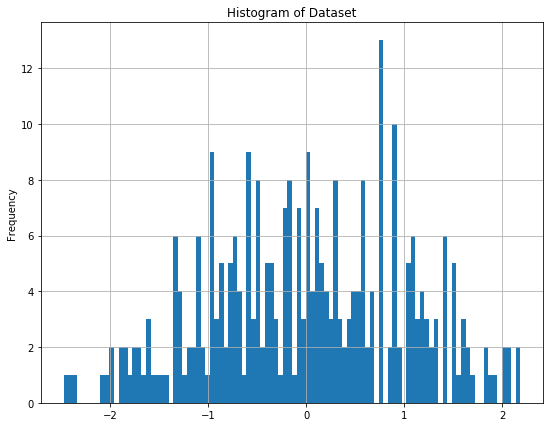

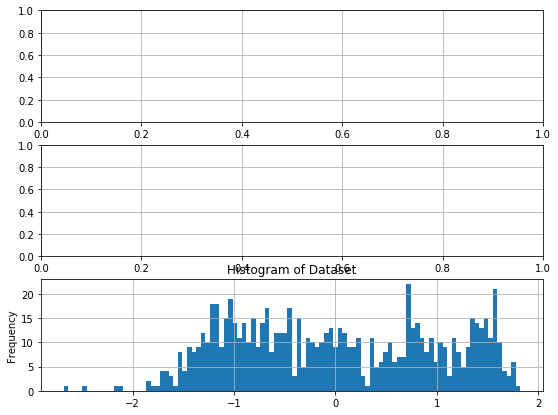

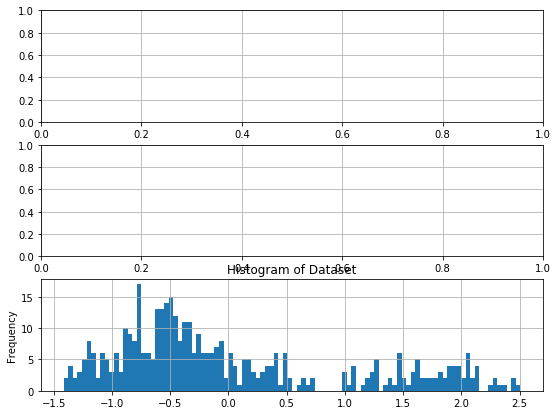

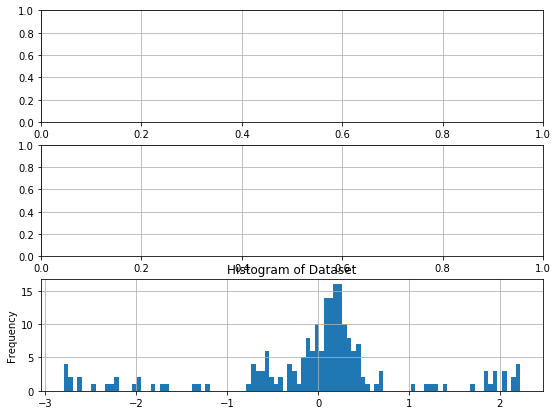

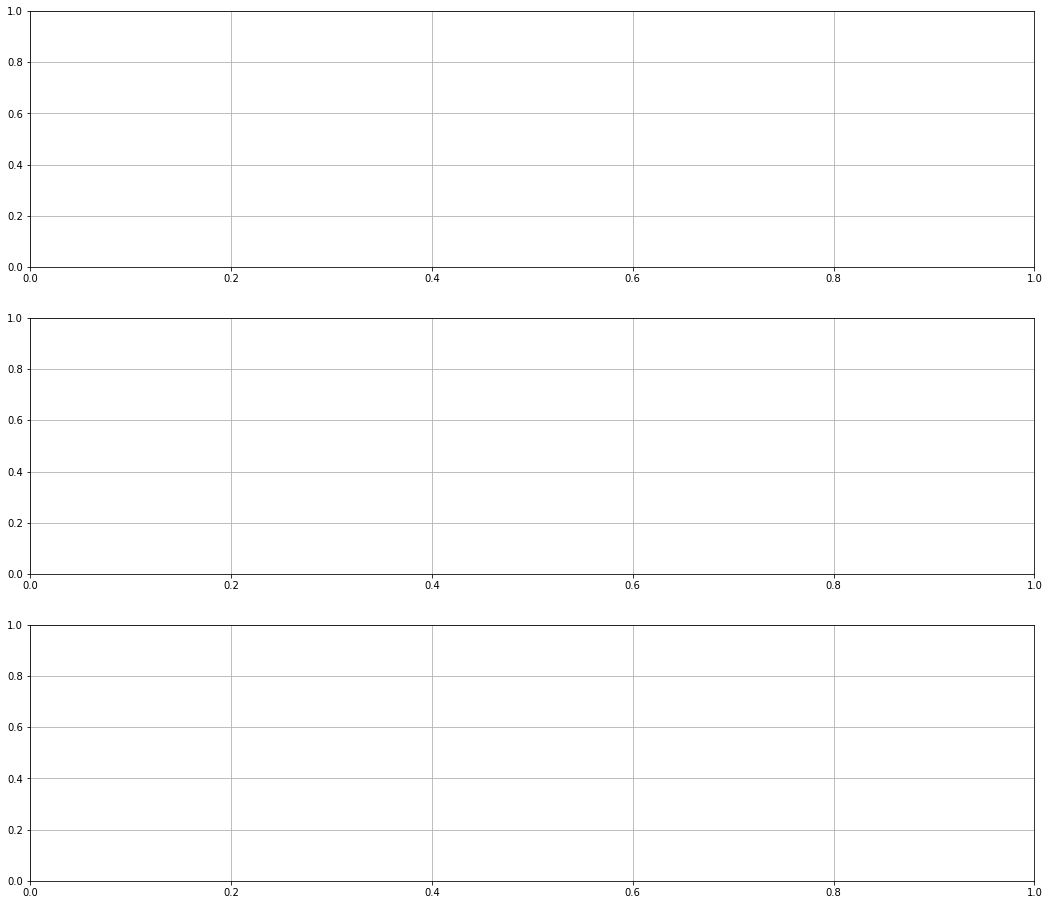

In [11]:
data_dir = 'dataset/sample_csv_files/'
target_dir = 'dataset/reader_csv_files/'
assetno = ['1']
for filename in os.listdir(data_dir):
    
    name,ext = os.path.splitext(filename)
    if ext != '.csv':continue
    infile = os.path.join(data_dir,filename)
    print("\nDetecting anomalies for {}\n".format(filename))
    
    
    kwargs1 = get_csv_kwargs(infile=infile,filename=filename,target_dir=target_dir,assetno=assetno[0],pthres=0.4)
    kwargs1['expected_run_length']=500
#     print('params: {}\n'.format(param))
   
    res = call(**kwargs1)
    print(res)

# Conclusion:
* Hence we observe that **Bayesian Changepoint Detection** works well only on level shifts or variational shift datasets over outlier or surge,sag datasets